In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/washingtonsubset-buildings/test_labels/1.4_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/2.2_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/2.4_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/1.1_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/2.1_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/2.3_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/1.3_buildings.png
/kaggle/input/washingtonsubset-buildings/test_labels/1.2_buildings.png
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_2_4.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_1_3.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_1_4.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_1_1.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_2_1.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_2_3.tif
/kaggle/input/washingtonsubset-buildings/test/OUTPUT_2_2.tif
/kagg

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album
import segmentation_models_pytorch as smp

In [3]:
DATA_DIR = '/kaggle/input/massachusetts-buildings-dataset/png'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

In [5]:
select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [6]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [7]:
class BuildingsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_rgb_values=None, augmentation=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)

In [8]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=1),
            album.VerticalFlip(p=1),
            album.RandomRotate90(p=1),
        ], p=0.75),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECBA(nn.Module):
    """
    Example channel-attention block using an ECA-like mechanism.
    """
    def __init__(self, channels, k_size=3):
        super(ECBA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)    # shape: (B, C, 1, 1)
        self.conv = nn.Conv1d(
            in_channels=1, 
            out_channels=1, 
            kernel_size=k_size, 
            padding=(k_size - 1) // 2, 
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)                      # shape: (B, C, 1, 1)
        y = y.squeeze(-1).permute(0, 2, 1)        # shape: (B, 1, C)
        y = self.conv(y)                          # shape: (B, 1, C)
        y = y.permute(0, 2, 1).unsqueeze(-1)      # shape: (B, C, 1, 1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class DoubleConvECBA(nn.Module):
    """
    A double-conv block that integrates the ECBA attention after each convolution.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConvECBA, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.ecba1 = ECBA(out_channels)  

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.ecba2 = ECBA(out_channels)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.ecba1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.ecba2(x)
        
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConvECBA(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return down_out, skip_out

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(
                in_channels - out_channels, 
                in_channels - out_channels, 
                kernel_size=2, 
                stride=2
            )
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (must be `conv_transpose` or `bilinear`)")

        self.double_conv = DoubleConvECBA(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv(x)
        return x

class UNet_ECBA(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet_ECBA, self).__init__()
        self.up_sample_mode = up_sample_mode

        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        self.bottleneck = DoubleConvECBA(512, 1024)

        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)

        x = self.bottleneck(x)

        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)

        x = self.conv_last(x)
        return x


In [12]:
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [13]:
class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        targets = torch.argmax(targets, dim=1)  # Convert one-hot encoded target to class indices
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets.long())
        return dice_loss + ce_loss

# IoU metric
import segmentation_models_pytorch as smp

# Initialize the IoU metric from segmentation_models_pytorch
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    
    # Return the IoU score
    return iou_score.item()



In [15]:


import segmentation_models_pytorch as smp
from tqdm import tqdm

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, optimizer, and learning rate scheduler
model = UNet_ECBA().to(DEVICE)


loss_fn = HybridLoss()
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

# Define IoU metric with threshold
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    # Return the IoU score
    return iou_score.item()

# Logging lists
train_logs_list = []
valid_logs_list = []

# Training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and IoU for training
        running_loss += loss.item()
        running_iou += calculate_iou(outputs, masks)
    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            # Accumulate loss and IoU for validation
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)
    val_loss = running_loss / len(valid_loader)
    val_iou = running_iou / len(valid_loader)

    # Log results
    train_logs_list.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_iou': train_iou})
    valid_logs_list.append({'epoch': epoch + 1, 'valid_loss': val_loss, 'valid_iou': val_iou})
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Update learning rate
    lr_scheduler.step()


Epoch 1/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train Loss: 1.2296, Train IoU: 0.0659
Val Loss: 1.2524, Val IoU: 0.0000
Epoch 2/100


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Train Loss: 1.0931, Train IoU: 0.2225
Val Loss: 1.2277, Val IoU: 0.0000
Epoch 3/100


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Train Loss: 1.0214, Train IoU: 0.3718
Val Loss: 1.1713, Val IoU: 0.0000
Epoch 4/100


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Train Loss: 0.9794, Train IoU: 0.4406
Val Loss: 1.0746, Val IoU: 0.0993
Epoch 5/100


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Train Loss: 0.9440, Train IoU: 0.4965
Val Loss: 0.9626, Val IoU: 0.4505
Epoch 6/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train Loss: 0.9211, Train IoU: 0.5263
Val Loss: 0.8890, Val IoU: 0.6738
Epoch 7/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.9364, Train IoU: 0.5618
Val Loss: 0.9024, Val IoU: 0.6864
Epoch 8/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.9102, Train IoU: 0.5784
Val Loss: 0.8353, Val IoU: 0.7520
Epoch 9/100


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Train Loss: 0.8975, Train IoU: 0.5879
Val Loss: 0.8160, Val IoU: 0.7900
Epoch 10/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.8820, Train IoU: 0.6156
Val Loss: 0.8726, Val IoU: 0.7010
Epoch 11/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.8509, Train IoU: 0.6319
Val Loss: 0.8127, Val IoU: 0.7533
Epoch 12/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.8609, Train IoU: 0.6360
Val Loss: 0.8155, Val IoU: 0.7576
Epoch 13/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.8522, Train IoU: 0.6536
Val Loss: 0.8031, Val IoU: 0.7725
Epoch 14/100


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train Loss: 0.8441, Train IoU: 0.6719
Val Loss: 0.8113, Val IoU: 0.7617
Epoch 15/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.8272, Train IoU: 0.6729
Val Loss: 0.8141, Val IoU: 0.7394
Epoch 16/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.8137, Train IoU: 0.6625
Val Loss: 0.7562, Val IoU: 0.7960
Epoch 17/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.8189, Train IoU: 0.6846
Val Loss: 0.7627, Val IoU: 0.7966
Epoch 18/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.8092, Train IoU: 0.6772
Val Loss: 0.7718, Val IoU: 0.8166
Epoch 19/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.8127, Train IoU: 0.6963
Val Loss: 0.7752, Val IoU: 0.7653
Epoch 20/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.7844, Train IoU: 0.7253
Val Loss: 0.8439, Val IoU: 0.6623
Epoch 21/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.7878, Train IoU: 0.7207
Val Loss: 0.7587, Val IoU: 0.8061
Epoch 22/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.7774, Train IoU: 0.7545
Val Loss: 0.7655, Val IoU: 0.7496
Epoch 23/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.7703, Train IoU: 0.7464
Val Loss: 0.7196, Val IoU: 0.8070
Epoch 24/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.7707, Train IoU: 0.6937
Val Loss: 0.7416, Val IoU: 0.7672
Epoch 25/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.7453, Train IoU: 0.7313
Val Loss: 0.7190, Val IoU: 0.8167
Epoch 26/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.7548, Train IoU: 0.7630
Val Loss: 0.7062, Val IoU: 0.8099
Epoch 27/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.7568, Train IoU: 0.7343
Val Loss: 0.7225, Val IoU: 0.7732
Epoch 28/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.7419, Train IoU: 0.7346
Val Loss: 0.7099, Val IoU: 0.7931
Epoch 29/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.7479, Train IoU: 0.7684
Val Loss: 0.7041, Val IoU: 0.7942
Epoch 30/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.7418, Train IoU: 0.7701
Val Loss: 0.7044, Val IoU: 0.8031
Epoch 31/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.7212, Train IoU: 0.7908
Val Loss: 0.6989, Val IoU: 0.7994
Epoch 32/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.7118, Train IoU: 0.7929
Val Loss: 0.7022, Val IoU: 0.7951
Epoch 33/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.7059, Train IoU: 0.7865
Val Loss: 0.6824, Val IoU: 0.8040
Epoch 34/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6969, Train IoU: 0.7777
Val Loss: 0.6666, Val IoU: 0.8143
Epoch 35/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.7016, Train IoU: 0.7812
Val Loss: 0.6839, Val IoU: 0.7928
Epoch 36/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.7171, Train IoU: 0.7771
Val Loss: 0.6832, Val IoU: 0.8090
Epoch 37/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6949, Train IoU: 0.7834
Val Loss: 0.6940, Val IoU: 0.7919
Epoch 38/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.7047, Train IoU: 0.7851
Val Loss: 0.6569, Val IoU: 0.8143
Epoch 39/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.6793, Train IoU: 0.7985
Val Loss: 0.6619, Val IoU: 0.8056
Epoch 40/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6828, Train IoU: 0.7935
Val Loss: 0.6326, Val IoU: 0.8177
Epoch 41/100


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train Loss: 0.6696, Train IoU: 0.8015
Val Loss: 0.6441, Val IoU: 0.8101
Epoch 42/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6671, Train IoU: 0.8147
Val Loss: 0.7182, Val IoU: 0.7512
Epoch 43/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6610, Train IoU: 0.8069
Val Loss: 0.6301, Val IoU: 0.8128
Epoch 44/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6417, Train IoU: 0.8042
Val Loss: 0.6386, Val IoU: 0.7982
Epoch 45/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.6661, Train IoU: 0.8083
Val Loss: 0.6236, Val IoU: 0.8193
Epoch 46/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6550, Train IoU: 0.8231
Val Loss: 0.6224, Val IoU: 0.8162
Epoch 47/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.6346, Train IoU: 0.8158
Val Loss: 0.6043, Val IoU: 0.8207
Epoch 48/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6577, Train IoU: 0.8052
Val Loss: 0.5994, Val IoU: 0.8200
Epoch 49/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.6351, Train IoU: 0.8152
Val Loss: 0.6453, Val IoU: 0.7743
Epoch 50/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6331, Train IoU: 0.8162
Val Loss: 0.6043, Val IoU: 0.8181
Epoch 51/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6342, Train IoU: 0.8213
Val Loss: 0.5942, Val IoU: 0.8204
Epoch 52/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6179, Train IoU: 0.8177
Val Loss: 0.5967, Val IoU: 0.8092
Epoch 53/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6153, Train IoU: 0.8173
Val Loss: 0.5816, Val IoU: 0.8270
Epoch 54/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.6174, Train IoU: 0.8138
Val Loss: 0.5842, Val IoU: 0.8235
Epoch 55/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6238, Train IoU: 0.8149
Val Loss: 0.5814, Val IoU: 0.8091
Epoch 56/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.6075, Train IoU: 0.8189
Val Loss: 0.5717, Val IoU: 0.8333
Epoch 57/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.6115, Train IoU: 0.8217
Val Loss: 0.5709, Val IoU: 0.8162
Epoch 58/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5910, Train IoU: 0.8224
Val Loss: 0.5706, Val IoU: 0.8260
Epoch 59/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5976, Train IoU: 0.8280
Val Loss: 0.5634, Val IoU: 0.8322
Epoch 60/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5913, Train IoU: 0.8270
Val Loss: 0.5570, Val IoU: 0.8276
Epoch 61/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5959, Train IoU: 0.8350
Val Loss: 0.5615, Val IoU: 0.8289
Epoch 62/100


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Train Loss: 0.5912, Train IoU: 0.8355
Val Loss: 0.5600, Val IoU: 0.8240
Epoch 63/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5977, Train IoU: 0.8373
Val Loss: 0.5472, Val IoU: 0.8325
Epoch 64/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5809, Train IoU: 0.8298
Val Loss: 0.5973, Val IoU: 0.7996
Epoch 65/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5810, Train IoU: 0.8108
Val Loss: 0.5690, Val IoU: 0.8189
Epoch 66/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5924, Train IoU: 0.8125
Val Loss: 0.5701, Val IoU: 0.8075
Epoch 67/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.5594, Train IoU: 0.8278
Val Loss: 0.5313, Val IoU: 0.8290
Epoch 68/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5812, Train IoU: 0.8190
Val Loss: 0.5335, Val IoU: 0.8333
Epoch 69/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5758, Train IoU: 0.8202
Val Loss: 0.5511, Val IoU: 0.8182
Epoch 70/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.5787, Train IoU: 0.8289
Val Loss: 0.5488, Val IoU: 0.8329
Epoch 71/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.5706, Train IoU: 0.8334
Val Loss: 0.5253, Val IoU: 0.8302
Epoch 72/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5494, Train IoU: 0.8292
Val Loss: 0.5295, Val IoU: 0.8313
Epoch 73/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5630, Train IoU: 0.8245
Val Loss: 0.6205, Val IoU: 0.7595
Epoch 74/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.5645, Train IoU: 0.8307
Val Loss: 0.6155, Val IoU: 0.7630
Epoch 75/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5626, Train IoU: 0.8196
Val Loss: 0.5189, Val IoU: 0.8297
Epoch 76/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5496, Train IoU: 0.8314
Val Loss: 0.5116, Val IoU: 0.8327
Epoch 77/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5518, Train IoU: 0.8257
Val Loss: 0.5360, Val IoU: 0.8172
Epoch 78/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5506, Train IoU: 0.8377
Val Loss: 0.5238, Val IoU: 0.8332
Epoch 79/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5413, Train IoU: 0.8374
Val Loss: 0.5169, Val IoU: 0.8107
Epoch 80/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.5301, Train IoU: 0.8272
Val Loss: 0.5169, Val IoU: 0.8180
Epoch 81/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5414, Train IoU: 0.8394
Val Loss: 0.5148, Val IoU: 0.8315
Epoch 82/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5481, Train IoU: 0.8353
Val Loss: 0.4996, Val IoU: 0.8315
Epoch 83/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5411, Train IoU: 0.8297
Val Loss: 0.4883, Val IoU: 0.8368
Epoch 84/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5480, Train IoU: 0.8230
Val Loss: 0.4990, Val IoU: 0.8268
Epoch 85/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5348, Train IoU: 0.8207
Val Loss: 0.5264, Val IoU: 0.8054
Epoch 86/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5265, Train IoU: 0.8440
Val Loss: 0.5368, Val IoU: 0.8053
Epoch 87/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.5155, Train IoU: 0.8377
Val Loss: 0.4772, Val IoU: 0.8394
Epoch 88/100


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Train Loss: 0.4972, Train IoU: 0.8429
Val Loss: 0.4814, Val IoU: 0.8311
Epoch 89/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.4940, Train IoU: 0.8509
Val Loss: 0.4736, Val IoU: 0.8409
Epoch 90/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.4922, Train IoU: 0.8536
Val Loss: 0.4761, Val IoU: 0.8304
Epoch 91/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.5046, Train IoU: 0.8449
Val Loss: 0.4725, Val IoU: 0.8386
Epoch 92/100


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Train Loss: 0.4867, Train IoU: 0.8488
Val Loss: 0.4607, Val IoU: 0.8405
Epoch 93/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5060, Train IoU: 0.8329
Val Loss: 0.4772, Val IoU: 0.8341
Epoch 94/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train Loss: 0.5086, Train IoU: 0.8279
Val Loss: 0.4747, Val IoU: 0.8259
Epoch 95/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.4948, Train IoU: 0.8293
Val Loss: 0.4565, Val IoU: 0.8348
Epoch 96/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train Loss: 0.4840, Train IoU: 0.8498
Val Loss: 0.4530, Val IoU: 0.8444
Epoch 97/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train Loss: 0.4844, Train IoU: 0.8568
Val Loss: 0.4737, Val IoU: 0.8410
Epoch 98/100


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train Loss: 0.4858, Train IoU: 0.8448
Val Loss: 0.4599, Val IoU: 0.8372
Epoch 99/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train Loss: 0.4807, Train IoU: 0.8528
Val Loss: 0.4508, Val IoU: 0.8409
Epoch 100/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

Train Loss: 0.4894, Train IoU: 0.8448
Val Loss: 0.4408, Val IoU: 0.8444


In [16]:
# Define test dataset and dataloader
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Function to evaluate model on test data
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)  # Using smp's IoU metric with threshold
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    return epoch_loss, epoch_iou

# Evaluate model on test data
test_loss, test_iou = evaluate_model(model, test_dataloader, loss_fn, DEVICE)
print(f"Evaluation on Test Data: Mean IoU Score: {test_iou:.4f}, Mean Dice Loss: {test_loss:.4f}")


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

Evaluation on Test Data: Mean IoU Score: 0.7866, Mean Dice Loss: 0.4683


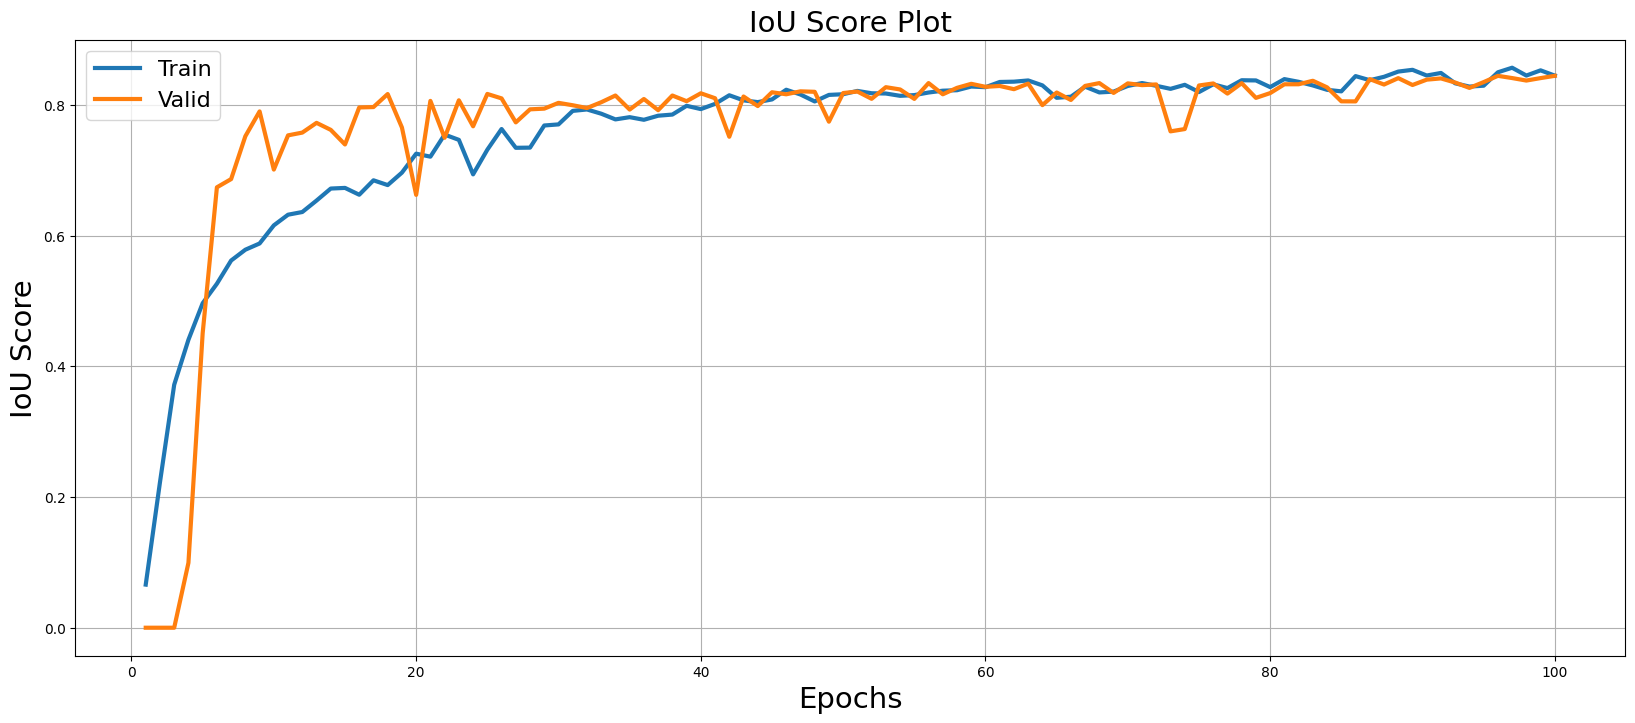

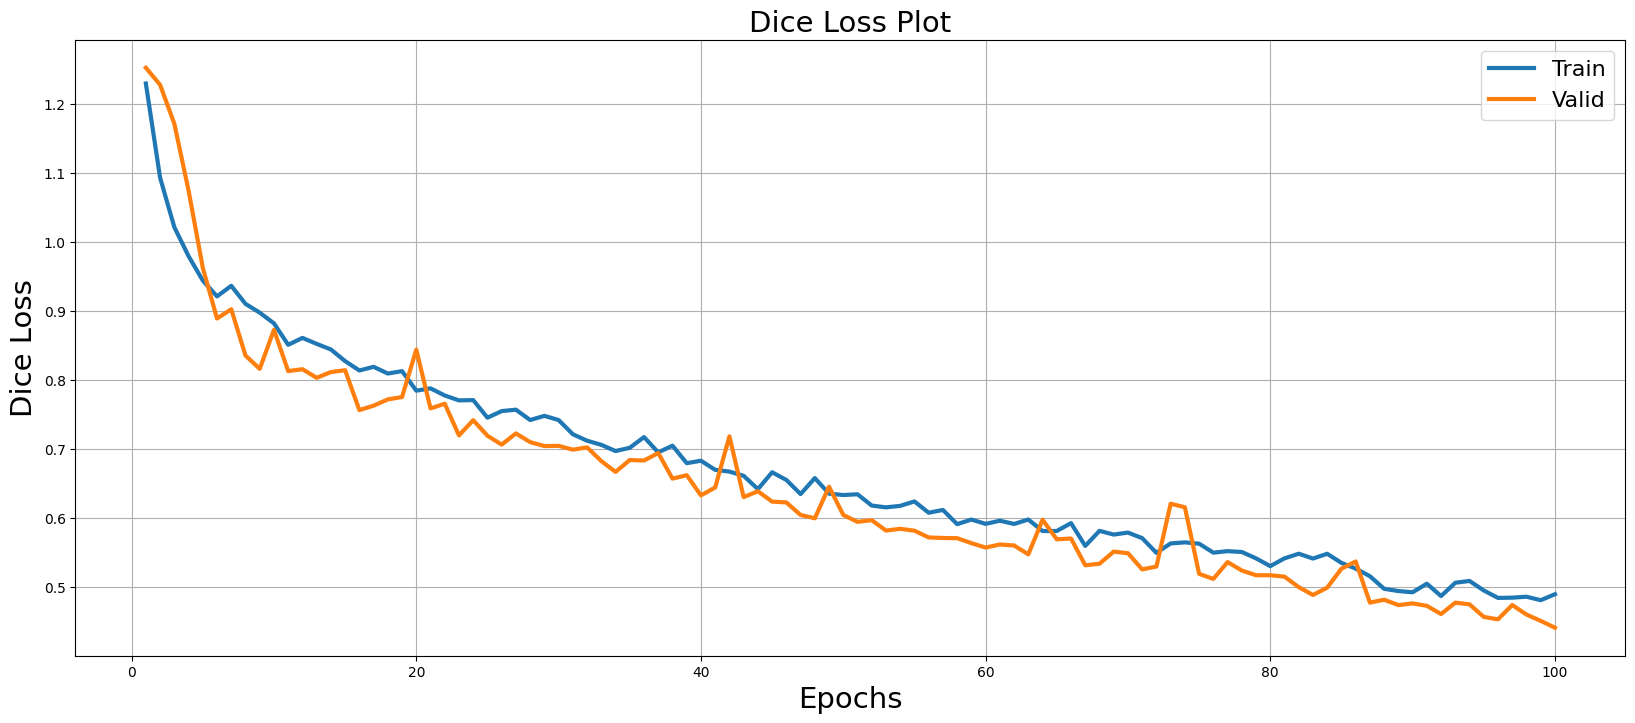

In [17]:
# Visualization of metrics
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_iou'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_iou'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_loss'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_loss'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [18]:
def save_predictions(model, dataloader, device, class_rgb_values, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader, desc="Saving Predictions")):
            images = images.to(device)
            outputs = model(images)
            predicted_masks = outputs.cpu().numpy()
            
            # Convert predictions to RGB format
            predicted_masks = np.argmax(predicted_masks, axis=1)
            decoded_preds = [colour_code_segmentation(mask, class_rgb_values) for mask in predicted_masks]
            
            for j, decoded_pred in enumerate(decoded_preds):
                # Convert to uint8 format
                decoded_pred = decoded_pred.astype(np.uint8)
                
                # Save each prediction as an image
                save_path = os.path.join(save_dir, f'pred_{i * len(decoded_preds) + j}.png')
                cv2.imwrite(save_path, cv2.cvtColor(decoded_pred, cv2.COLOR_RGB2BGR))

# Specify the directory for saving predictions
predictions_dir = './predictions'
save_predictions(model, test_dataloader, DEVICE, select_class_rgb_values, predictions_dir)


Saving Predictions: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


In [19]:
DATA_DIR_2 = '../input/sat_images'

x_test_dir_2 = '../input/washington-buildingsubset/'
y_test_dir_2 = '../input/washingtonsubset-buildings/test_labels/'

def resizeHelper(diry, output_dir, resolution):
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    for image_id in sorted(os.listdir(diry)):
        input_path = os.path.join(diry, image_id)
        output_path = os.path.join(output_dir, image_id)  # Preserve filename
        
        img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Skipping {image_id} (could not read)")
            continue

        img_resized = cv2.resize(img, resolution, interpolation=cv2.INTER_AREA)
        cv2.imwrite(output_path, img_resized)
        print(f"Saved: {output_path}")

resizeHelper(x_test_dir_2, "./resizedImages", (1500, 1500))
resizeHelper(y_test_dir_2, "./resizedLabels", (1500, 1500))

xt2_final = "./resizedImages"
yt2_final = "./resizedLabels"

Saved: ./resizedImages/OUTPUT_1_1.png
Saved: ./resizedImages/OUTPUT_1_2.png
Saved: ./resizedImages/OUTPUT_1_3.png
Saved: ./resizedImages/OUTPUT_1_4.png
Saved: ./resizedImages/OUTPUT_2_1.png
Saved: ./resizedImages/OUTPUT_2_2.png
Saved: ./resizedImages/OUTPUT_2_3.png
Saved: ./resizedImages/OUTPUT_2_4.png
Saved: ./resizedLabels/1.1_buildings.png
Saved: ./resizedLabels/1.2_buildings.png
Saved: ./resizedLabels/1.3_buildings.png
Saved: ./resizedLabels/1.4_buildings.png
Saved: ./resizedLabels/2.1_buildings.png
Saved: ./resizedLabels/2.2_buildings.png
Saved: ./resizedLabels/2.3_buildings.png
Saved: ./resizedLabels/2.4_buildings.png


In [20]:
xt2_final = "./resizedImages"
yt2_final = "./resizedLabels"

test_dataset_2 = BuildingsDataset(
    xt2_final, 
    yt2_final, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

print([os.path.join("./resizedImages", image_id) for image_id in sorted(os.listdir('./resizedImages'))])

test_dataloader_2 = DataLoader(test_dataset_2)

['./resizedImages/OUTPUT_1_1.png', './resizedImages/OUTPUT_1_2.png', './resizedImages/OUTPUT_1_3.png', './resizedImages/OUTPUT_1_4.png', './resizedImages/OUTPUT_2_1.png', './resizedImages/OUTPUT_2_2.png', './resizedImages/OUTPUT_2_3.png', './resizedImages/OUTPUT_2_4.png']


In [21]:
test_loss, test_iou = evaluate_model(model, test_dataloader_2, loss_fn, DEVICE)
print(f"Evaluation on Test Data: Mean IoU Score: {test_iou:.4f}, Mean Dice Loss: {test_loss:.4f}")

predictions_dir_2 = './predictions_2'
save_predictions(model, test_dataloader_2, DEVICE, select_class_rgb_values, predictions_dir_2)

100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Evaluation on Test Data: Mean IoU Score: 0.3405, Mean Dice Loss: 0.9586


Saving Predictions: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]
